# EDA-Calidad del dataset Air_Quality

## Librerías

In [190]:
import os
import warnings

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from deep_translator import GoogleTranslator
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import LabelEncoder

## Ajustes

Se ignoran los warnings.

In [192]:
warnings.filterwarnings("ignore")

Se hacen unas modificaciones en la configuracion para que los resultados salgan completos.

In [193]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

## Diccionario de Datos

Se importa el diccionario y se obtiene su info.

In [194]:
ruta_actual = os.getcwd()

ruta_del_proyecto = os.path.dirname(
    ruta_actual
    )

ruta_del_diccionario = os.path.join(
    ruta_del_proyecto, 
    'assets', 
    'Data_dictionary', 
    'Data-Dictionary-Air_Quality_2024.xlsx'
    )

diccionario = pd.read_excel(
    ruta_del_diccionario, 
    sheet_name='Column Information', 
    header=1
    )

diccionario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Column Name              13 non-null     object 
 1   Column Description       13 non-null     object 
 2   Expected/Allowed Values  2 non-null      object 
 3   Field Limitations        10 non-null     object 
 4   Additional Notes         0 non-null      float64
dtypes: float64(1), object(4)
memory usage: 652.0+ bytes


Se va a eliminar la última columna llamada Additional Notes porque solo tiene nulos y se necesita optimizar la visualizacion.

In [195]:
diccionario.drop(columns='Additional Notes', inplace=True)

Se va a traducir el diccionario.

In [196]:
def traducir_nombres_columnas(columnas, idioma_destino):
    translator = GoogleTranslator(source='en', target=idioma_destino)
    return [translator.translate(nombre) for nombre in columnas]

diccionario.columns = traducir_nombres_columnas(diccionario.columns, 'es')

def traducir_fila(texto, idioma_destino):
    translator = GoogleTranslator(source='en', target=idioma_destino)
    return translator.translate(texto)

diccionario.iloc[0] = diccionario.iloc[0].apply(lambda x: traducir_fila(x, 'es'))

diccionario.fillna("", inplace=True)

def traducir_texto(texto, idioma_destino):
    translator = GoogleTranslator(source='en', target=idioma_destino)
    return translator.translate(texto)

columnas_a_traducir = ['Descripción de la columna', 'Valores esperados/permitidos', 'Limitaciones del campo']

for columna in columnas_a_traducir:
    diccionario[columna] = diccionario[columna].apply(lambda x: traducir_texto(x, 'es'))
    
diccionario

,Nombre de la columna,Descripción de la columna,Valores esperados/permitidos,Limitaciones del campo
0,Nombre de la columna exactamente como aparece en el conjunto de datos.,Una explicación breve y en lenguaje sencillo de lo que significan los datos de la columna.,"Especifique si existe un rango esperado y/o formato de valores posibles. Por ejemplo, si el tipo de datos es Fecha y hora, este campo indicará si la marca de tiempo es MM/DD/AAAA o MM/AAAA. Si el nombre de la columna está helado, este campo puede indicar que los valores pueden ser Chocolate, Vainilla o Fresa.\n\nSi es relevante, este campo especifica la unidad de medida del campo de datos, p. ej., millas, millones, valor en dólares, millas, pies, año, etc.","Describe las características únicas o las posibles limitaciones analíticas que presenta este campo, incluyendo: \n- el razonamiento para cualquier valor nulo, cero o vacío en los datos\n- si los datos en la columna fueron integrados desde otro conjunto de datos u organización\n- si los datos cubiertos incluyen un período de tiempo diferente\n- la fuente de la columna y cómo se generaron los datos en la columna. \n\nPor ejemplo, la información sobre cómo se generaron los datos en esta columna puede incluir si los datos fueron informados directamente por una persona, generados por un sistema de una base de datos o un sistema de una agencia, derivados a través de la manipulación analítica de otros campos o registros; u obtenidos de una agencia diferente."
1,unique_id,Identificador de registro único,,
2,indicator_id,Identificador del tipo de valor medido en el tiempo y el espacio.,,"Los indicadores tienen la misma fuente de datos, pero pueden dividirse en diferentes medidas"
3,name,Nombre del indicador,,"Los indicadores tienen la misma fuente de datos, pero pueden dividirse en diferentes medidas"
4,measure,Cómo se mide el indicador,,"Esto podría indicar que los valores de los datos son tasas, recuentos o porcentajes, así como también si la medida es una estratificación de los datos del indicador."
5,measure_info,Información (como unidades) sobre la medida,,
6,geo_type_name,Tipo de geografía,UHF' significa barrios del Fondo Hospitalario Unido,"Por ejemplo, los distritos de la ciudad, del municipio y de la comunidad son tipos de geografía diferentes."
7,geo_join_id,"Identificador del área geográfica del barrio, utilizado para unir a archivos de geografía cartográfica para realizar mapas temáticos",,Haga referencia a geo_type_name para saber con qué archivos de geografía unirse
8,geo_place_name,Nombre del barrio,,Podría ser 'Brownsville' o 'Brooklyn' u otra designación dependiendo del tipo de geografía.
9,time_period,Descripción del tiempo al que se aplican los datos,,"Podría ser un año, un rango de años o una temporada, por ejemplo."


## Importación del Dataset

Se importa el dataset.

In [197]:
ruta_actual = os.getcwd()

ruta_del_proyecto = os.path.dirname(
    ruta_actual
    )

ruta_del_dataset = os.path.join(
    ruta_del_proyecto, 
    'assets', 
    'Datasets', 
    'Air_Quality_20241206.csv'
    )

air_quality = pd.read_csv(
    ruta_del_dataset
    )

## Exploración General

Primeras cinco filas.

In [198]:
air_quality.head(5)

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,179772,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,409.0,Southeast Queens,2015,01/01/2015,0.3,NaN
1,179785,640,Boiler Emissions- Total SO2 Emissions,Number per km2,number,UHF42,209.0,Bensonhurst - Bay Ridge,2015,01/01/2015,1.2,NaN
2,178540,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,209.0,Bensonhurst - Bay Ridge,Annual Average 2012,12/01/2011,8.6,NaN
3,178561,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Annual Average 2012,12/01/2011,8.0,NaN
4,823217,365,Fine particles (PM 2.5),Mean,mcg/m3,UHF42,409.0,Southeast Queens,Summer 2022,06/01/2022,6.1,NaN


## Tamaño del Dataset

Se obtienen la cantidad de filas y la cantidad de columnas.

In [199]:
print("Cantidad de filas: ")
print(air_quality.shape[0])
print()
print("Cantidad de columnas:")
print(air_quality.shape[1])

Cantidad de filas: 
18025

Cantidad de columnas:
12


## Valores Faltantes

Se seleccionan las columnas de tipo object.

In [200]:
columnas_object = air_quality.select_dtypes(include='object').columns

columnas_object

Index(['Name', 'Measure', 'Measure Info', 'Geo Type Name', 'Geo Place Name',
       'Time Period', 'Start_Date'],
      dtype='object')

Se comprueba si tienen cadenas vacias.

In [201]:
filas_con_valores_vacios = air_quality[
    columnas_object].apply(lambda x: x == "").any(axis=1)

print('Cantidad de valores faltantes en las columnas de tipo object:')
print(filas_con_valores_vacios.sum())

Cantidad de valores faltantes en las columnas de tipo object:
0


**Esta completo**

## Valores Nulos

In [202]:
air_quality.isnull().sum()

Unique ID             0
Indicator ID          0
Name                  0
Measure               0
Measure Info          0
Geo Type Name         0
Geo Join ID           9
Geo Place Name        9
Time Period           0
Start_Date            0
Data Value            0
Message           18025
dtype: int64

Dos columnas tienen 9 valores nulos. La última columna, llamada Message, tiene todos sus valores nulos.

**Hay que eliminar la columna Message.**

## Tipos de Datos

Se obtiene el nombre de cada columna y su tipo de dato.

In [203]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

Todas las columnas excepto 'Geo Join ID' y 'Start_Date' tienen su tipo correcto:

- 'Unique ID' y 'Indicator ID' al ser IDs tienen el tipo correcto que es int64.
- 'Name', 'Measure', 'Measure Info', 'Geo Type Name' y 'Geo Place Name' al ser Datos Categóricos tienen el tipo correcto que es object.
- 'Time Period' al tener descripciones de tiempo tiene el tipo correcto que es object.

La columna 'Geo Join ID' es un ID por lo que su tipo deberia ser int64 y no float64. La causa por la que su tipo esta como float64 es porque tiene nulos.

**Hay que recuperar los IDs perdidos de la columna 'Geo Join ID' buscando en las demas filas.**

La columna 'Start_Date' tiene fechas por lo que su tipo deberia ser datetime64[ns] y no object. Se debe cambiar para facilidad de calculos.

**Hay que cambiar el tipo de la columna 'Start_Date' al tipo datetime64[ns].**

## Valores Duplicados

In [204]:
print("Cantidad de duplicados:")
print(air_quality.duplicated().sum())

Cantidad de duplicados:
0


**Sin duplicados en todo el Dataset**

Ayuda Memoria para encontrar los IDs unicos del dataset.

In [205]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

Se calcula solo la columna 'Unique ID' porque tiene el indicador único de cada fila.

Se calcula la cantidad de IDs de la columna 'Unique ID' y la cantidad las de filas para que quede en evidencia la anterior afirmación.

In [206]:
print('Cantidad de valores de la columna "Unique ID":')
print(air_quality['Unique ID'].nunique())
print()
print('Cantidad de filas del dataset:')
print(air_quality.shape[0])

Cantidad de valores de la columna "Unique ID":
18025

Cantidad de filas del dataset:
18025


Se calcula la cantidad de duplicados.

In [207]:
print("Cantidad de duplicados:")
print(air_quality['Unique ID'].duplicated().sum())

Cantidad de duplicados:
0


**Sin duplicados en la columna Unique ID**

## Outliers y Distribución

### Columna Numérica 'Data Value'

Ayuda Memoria

In [208]:
air_quality.dtypes

Unique ID           int64
Indicator ID        int64
Name               object
Measure            object
Measure Info       object
Geo Type Name      object
Geo Join ID       float64
Geo Place Name     object
Time Period        object
Start_Date         object
Data Value        float64
Message           float64
dtype: object

La columna 'Data Value' es la unica columna cuantitativa. Las demás son IDs. Y la columna 'Message' esta vacía.

Se obtienen los cuartiles y la mediana.

In [209]:
Q1 = air_quality['Data Value'].quantile(0.25)
print('Primer cuartil:')
print(Q1)

print()

mediana = air_quality['Data Value'].median()
print('Mediana')
print(mediana)

print()

Q3 = air_quality['Data Value'].quantile(0.75)
print('Tercer cuartil:')
print(Q3)

Primer cuartil:
8.9

Mediana
15.2

Tercer cuartil:
26.7


Se obtiene el rango intercuartilico.

In [210]:
IQR = Q3 - Q1
print('IQR:')
print(IQR)

IQR:
17.799999999999997


Se obtienen los limites.

In [211]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print('Limite Inferior')
print(lower_bound)

print()

print('Limite Superior')
print(upper_bound)

Limite Inferior
-17.799999999999997

Limite Superior
53.39999999999999


#### Gráfico Histograma

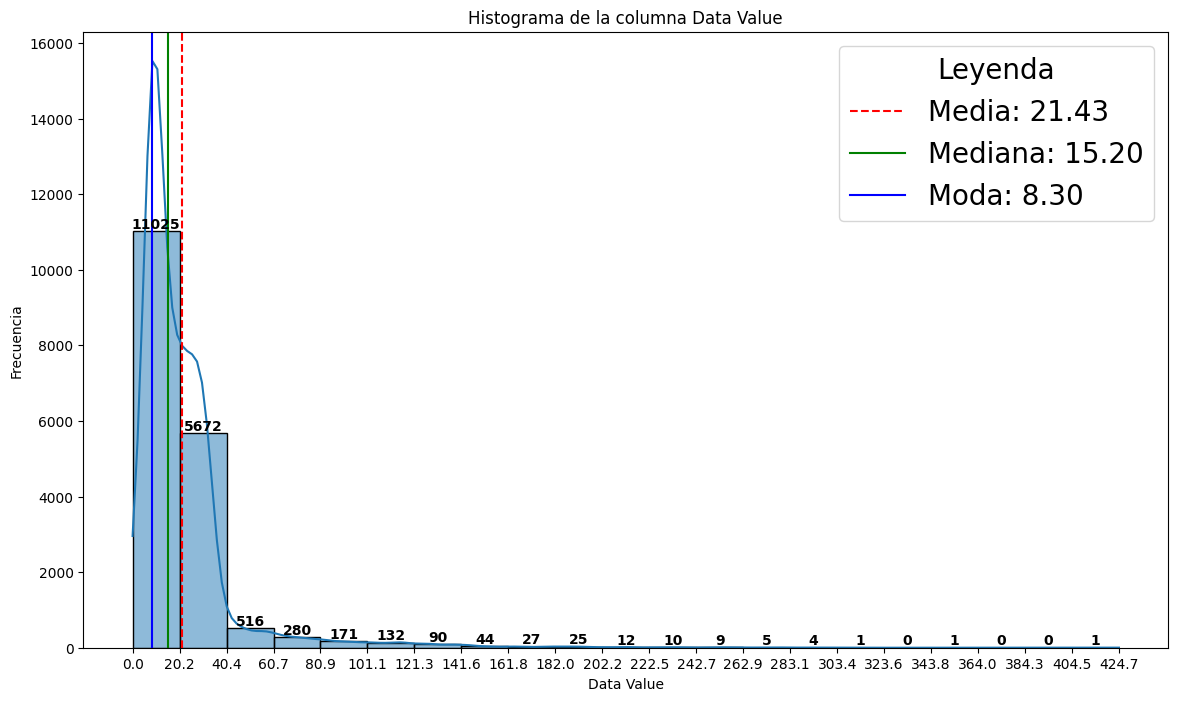

Cantidad de bins: 
Número de bins: 21

La media es: 
21.43

La mediana es: 
15.2

La moda es: 
8.3


In [212]:
mean = np.mean(air_quality['Data Value']) 
median = np.median(air_quality['Data Value']) 
mode = stats.mode(air_quality['Data Value'])[0]

binwidth = 20

num_bins = int((np.max(air_quality['Data Value']) - np.min(air_quality['Data Value'])) / binwidth)

plt.figure(figsize=(14, 8))
hist = sns.histplot(x=air_quality['Data Value'], binwidth=binwidth, kde=True)
plt.title('Histograma de la columna Data Value')
plt.xlabel('Data Value')
plt.ylabel('Frecuencia')

for patch in hist.patches:
    freq = int(patch.get_height())
    
    x = patch.get_x() + patch.get_width() / 2
    y = freq
    
    hist.annotate(f'{freq}', (x, y), ha='center', va='bottom', fontsize=10, fontweight='bold', color='black', rotation=0)

bin_width = hist.patches[0].get_width()
bin_edges = np.arange(0, bin_width * len(hist.patches) + 1, bin_width)
plt.xticks(bin_edges)

plt.axvline(mean, color='r', linestyle='--', label=f'Media: {mean:.2f}')
plt.axvline(median, color='g', linestyle='-', label=f'Mediana: {median:.2f}')
plt.axvline(mode, color='b', linestyle='-', label=f'Moda: {mode:.2f}')

plt.legend(title='Leyenda', fontsize=20, title_fontsize='20')

plt.show()
print('Cantidad de bins: ')
print(f'Número de bins: {num_bins}')
print()
print('La media es: ')
print(mean.round(2))
print()
print('La mediana es: ')
print(median)
print()
print('La moda es: ')
print(mode)

Se agrupan los datos de a 20 lo que divide la cantidad de datos en 21 grupos.

La mayoria de los valores están ubicados en el primer grupo que esta entre 0 y 40.4.

Luego el resto de los grupos se reducen drasticamente.

#### Gráfico Boxplot

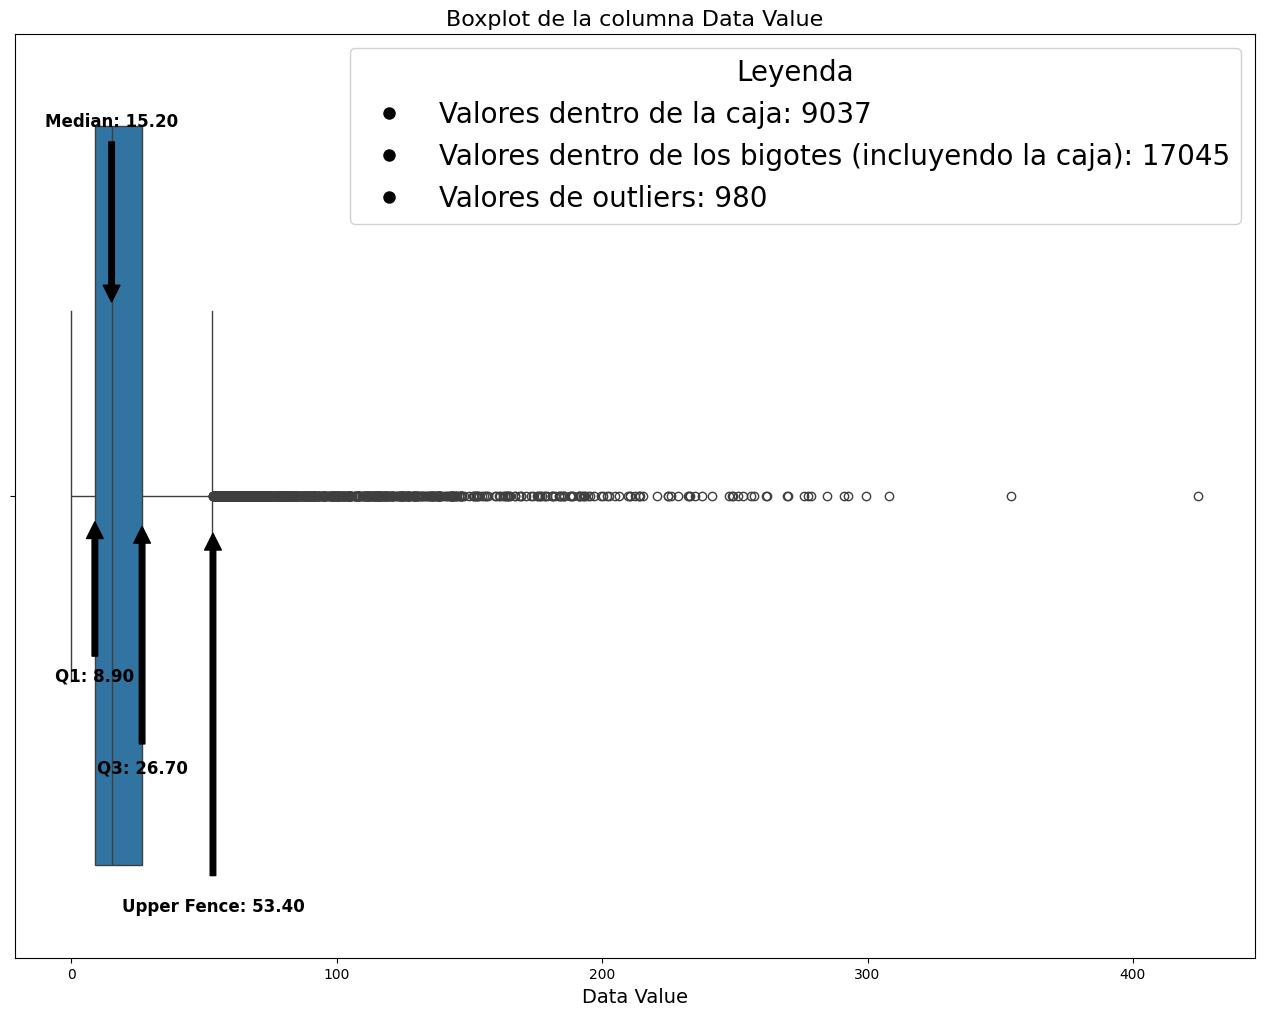

In [213]:
plt.figure(figsize=(16, 12))
boxplot = sns.boxplot(x=air_quality['Data Value'])
plt.title('Boxplot de la columna Data Value', fontsize=16)
plt.xlabel('Data Value', fontsize=14)

stats = air_quality['Data Value'].describe(percentiles=[.25, .5, .75])
q1 = stats['25%']
median = stats['50%']
q3 = stats['75%']
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

outliers = air_quality[(air_quality['Data Value'] < lower_fence) | (air_quality['Data Value'] > upper_fence)].shape[0]

within_box = air_quality[(air_quality['Data Value'] >= q1) & (air_quality['Data Value'] <= q3)].shape[0]
within_whiskers = air_quality[(air_quality['Data Value'] >= lower_fence) & (air_quality['Data Value'] <= upper_fence)].shape[0]

plt.annotate(f'Median: {median:.2f}', xy=(median, -0.2), xytext=(median, -0.4), ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, fontweight='bold')
plt.annotate(f'Q1: {q1:.2f}', xy=(q1, 0.02), xytext=(q1, 0.2), ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, fontweight='bold')
plt.annotate(f'Q3: {q3:.2f}', xy=(q3, 0.02), xytext=(q3, 0.3), ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, fontweight='bold')
plt.annotate(f'Upper Fence: {upper_fence:.2f}', xy=(upper_fence, 0.02), xytext=(upper_fence, 0.45), ha='center',
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, fontweight='bold')

legend_labels = [
    f'Valores dentro de la caja: {within_box}',
    f'Valores dentro de los bigotes (incluyendo la caja): {within_whiskers}',
    f'Valores de outliers: {outliers}'
]

legend_elements = [Line2D([0], [0], color='w', marker='o', markerfacecolor='black', markersize=10, label=f'Valores dentro de la caja: {within_box}'),
                   Line2D([0], [0], color='w', marker='o', markerfacecolor='black', markersize=10, label=f'Valores dentro de los bigotes (incluyendo la caja): {within_whiskers}'),
                   Line2D([0], [0], color='w', marker='o', markerfacecolor='black', markersize=10, label=f'Valores de outliers: {outliers}')]

plt.legend(handles=legend_elements, fontsize=20, loc='upper right', frameon=True, framealpha=0.9, facecolor='white', title='Leyenda', title_fontsize='20')

plt.show()


La mayoría de los valores se encuentran entre 8.90 y 26.70

La mediana es el valor 15.20

Luego del valor 53.40 hay outliers

**Hay que eliminar los valores outliers porque son pocos y el sesgo es demasiado marcado.**

### Columnas Categóricas

Se seleccionan las columnas categoricas.

In [214]:
columnas_categoricas = air_quality.select_dtypes(object).columns
print("Columnas Categóricas:", columnas_categoricas)

Columnas Categóricas: Index(['Name', 'Measure', 'Measure Info', 'Geo Type Name', 'Geo Place Name',
       'Time Period', 'Start_Date'],
      dtype='object')


Las columnas 'Geo Place Name', 'Time Period' y 'Start_Date' no van a ser analizadas.

La columna 'Geo Place Name' tiene todos lo barrios de Nueva York. Son muchos. Como este analisis es a nivel general se lo va a ignorar en este EDA.

Las columnas 'Time Period' y 'Start_Date' son indicadores de tiempo por lo que seran ignoradas en este EDA.

In [217]:
columnas_categoricas = ['Name', 'Measure', 'Measure Info', 'Geo Type Name']

#### Barplot de las Columnas Categóricas

Análisis de la columna Name


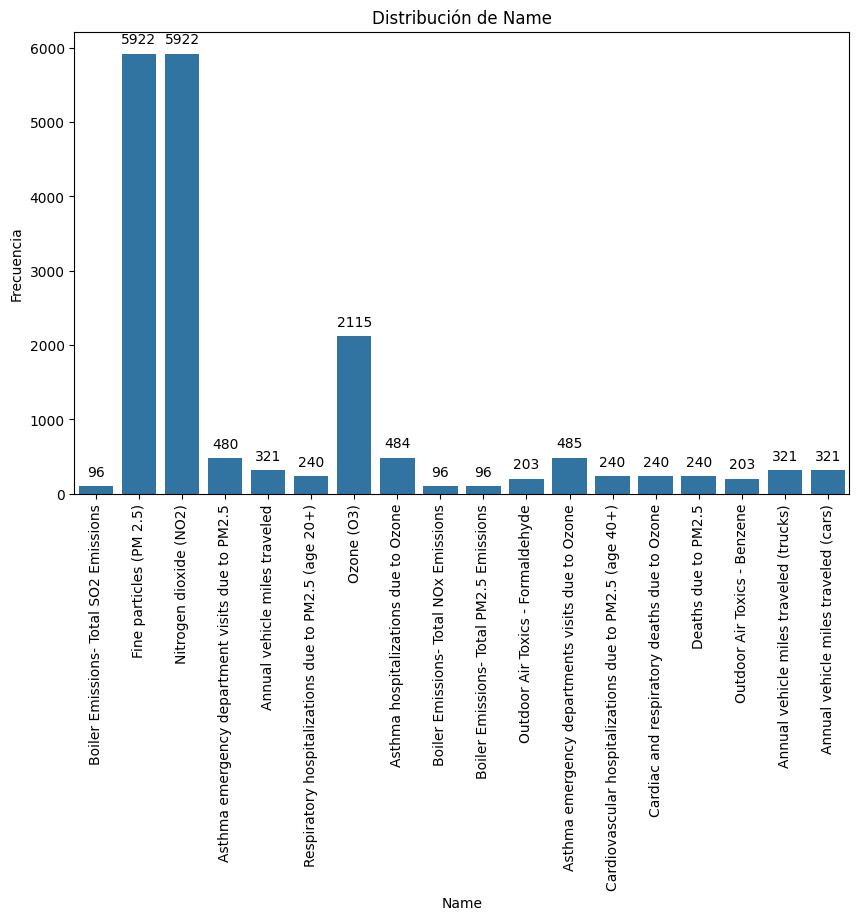


En la columna 'Name' hay dos categorías dominantes: 'Fine particles' y 'Nitrogen dioxide'. Ambas poseen la misma cantidad.



,Categoria,Definicion
0,Boiler Emissions- Total SO2 Emissions,Las emisiones totales de dióxido de azufre (SO2) producidas por calderas. El SO2 es un contaminante atmosférico que puede causar problemas respiratorios y contribuir a la lluvia ácida.
1,Fine particles (PM 2.5),"Partículas finas con un diámetro de 2.5 micrómetros o menos. Pueden penetrar profundamente en los pulmones y causar problemas de salud graves, como enfermedades respiratorias y cardiovasculares."
2,Nitrogen dioxide (NO2),"Dióxido de nitrógeno, un gas tóxico y contaminante atmosférico que puede irritar las vías respiratorias y agravar enfermedades pulmonares."
3,Asthma emergency department visits due to PM2.5,Visitas a las salas de emergencia por asma relacionadas con la exposición a partículas finas (PM2.5). La inhalación de PM2.5 puede desencadenar ataques de asma y otros problemas respiratorios.
4,Annual vehicle miles traveled,Millas recorridas anualmente por vehículos. Este indicador se utiliza para medir la cantidad de tráfico y sus efectos en la calidad del aire.
5,Respiratory hospitalizations due to PM2.5 (age 20+),"Hospitalizaciones por problemas respiratorios en personas de 20 años o más, atribuibles a la exposición a partículas finas (PM2.5)."
6,Ozone (O3),"Ozono, un gas que puede ser beneficioso en la estratosfera (donde forma la capa de ozono) pero perjudicial a nivel del suelo, donde puede causar problemas respiratorios."
7,Asthma hospitalizations due to Ozone,"Hospitalizaciones por asma relacionadas con la exposición al ozono a nivel del suelo, que puede irritar y dañar las vías respiratorias."
8,Boiler Emissions- Total NOx Emissions,Las emisiones totales de óxidos de nitrógeno (NOx) producidas por calderas. Los NOx son contaminantes que contribuyen a la formación de ozono troposférico y smog.
9,Boiler Emissions- Total PM2.5 Emissions,Las emisiones totales de partículas finas (PM2.5) producidas por calderas.



Análisis de la columna Measure


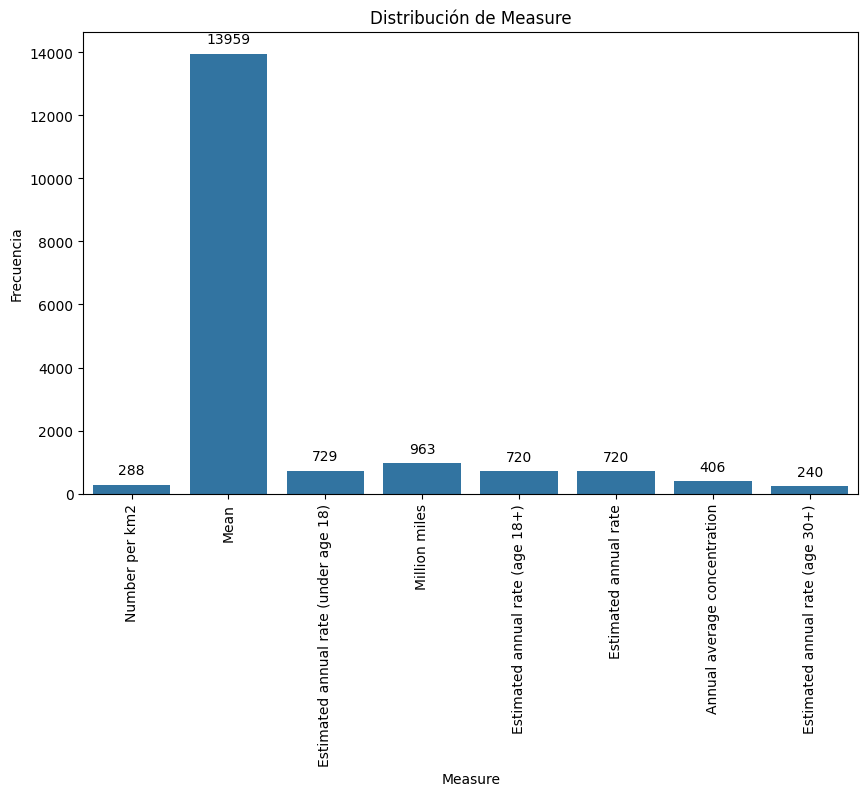


En la columna 'Measure' la categoría dominante es 'mean', también llamado promedio.



,Categoria,Definicion
0,Number per km2,"La cantidad de ocurrencias o entidades por kilómetro cuadrado. Esta medida se utiliza para expresar la densidad de algo en un área específica, como la densidad de población, vehículos, eventos, etc."
1,Mean,La media aritmética de un conjunto de valores. Se calcula sumando todos los valores y dividiéndolos por el número total de valores. Es una medida común de tendencia central en estadísticas.
2,Estimated annual rate (under age 18),La tasa anual estimada de un evento o condición específica en la población menor de 18 años. Esta tasa se calcula generalmente en función de datos históricos y proyecciones estadísticas.
3,Million miles,"Una medida de distancia que equivale a un millón de millas. Se puede utilizar para expresar grandes distancias recorridas, como en el caso de millas recorridas anualmente por vehículos."
4,Estimated annual rate (age 18+),La tasa anual estimada de un evento o condición específica en la población de 18 años o más. Esta tasa se basa en datos históricos y proyecciones para esa franja etaria.
5,Estimated annual rate,"La tasa anual estimada de un evento o condición específica, sin restricción de edad. Representa la frecuencia con la que se espera que ocurra un evento en un año determinado."
6,Annual average concentration,La concentración promedio anual de una sustancia o contaminante en el aire. Esta medida se utiliza para evaluar la exposición a largo plazo de poblaciones a ciertos contaminantes y es crucial en estudios de calidad del aire.
7,Estimated annual rate (age 30+),"La tasa anual estimada de un evento o condición específica en la población de 30 años o más. Similar a las tasas para otros grupos etarios, se basa en datos y proyecciones para esa franja de edad."



Análisis de la columna Measure Info


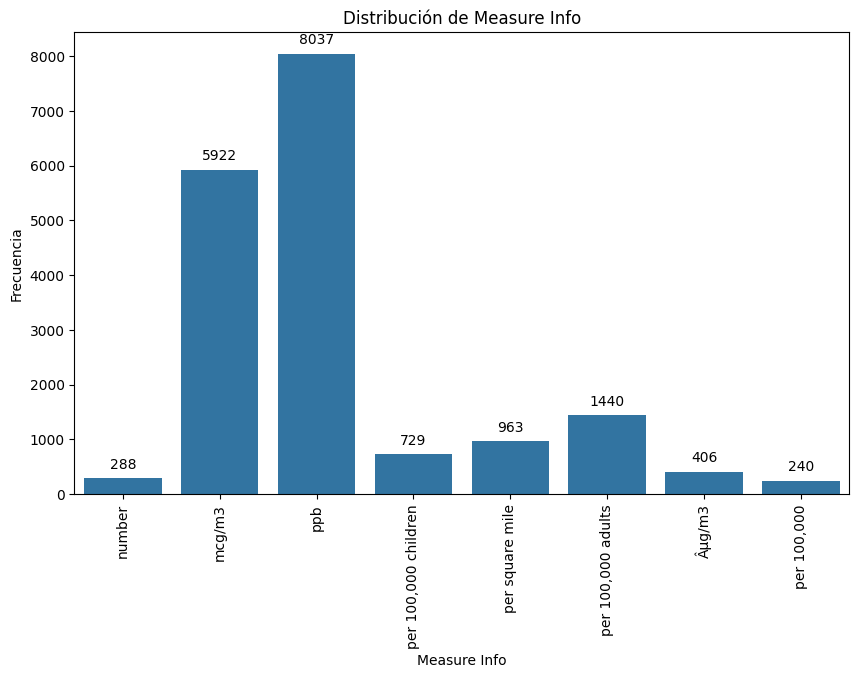


En la columna 'Measure Info' las categorías dominantes son: en primer lugar, 'ppb' y, en segundo lugar, 'mcg/m3'.



,Categoria,Definicion
0,number,"Un valor numérico que puede representar cualquier cantidad contable o medible. En el contexto de los datos, podría referirse a una cantidad específica de eventos, individuos, o cualquier otro elemento cuantificable."
1,mcg/m3,"Unidad de medida de concentración que indica la cantidad de una sustancia en microgramos presente en un metro cúbico de aire. Se utiliza comúnmente para medir la concentración de contaminantes en la atmósfera, como partículas finas (PM2.5)."
2,ppb,Unidad de medida de concentración que indica el número de partes de una sustancia por mil millones de partes del total. Se usa para medir contaminantes en el aire y el agua a niveles muy bajos.
3,"per 100,000 children","Una tasa que indica la frecuencia de un evento en un grupo de 100,000 niños. Es útil para normalizar datos y comparar la incidencia de eventos entre diferentes poblaciones o regiones."
4,per square mile,"Una medida de densidad que indica la cantidad de ocurrencias o entidades por milla cuadrada. Se utiliza para expresar densidades de población, eventos o fenómenos geográficos."
5,"per 100,000 adults","Una tasa que indica la frecuencia de un evento en un grupo de 100,000 adultos. Esta tasa permite comparar la incidencia de eventos entre diferentes poblaciones o regiones, normalizando los datos."
6,Âµg/m3,"Similar a `mcg/m³`, esta unidad de medida de concentración indica la cantidad de una sustancia en microgramos presente en un metro cúbico de aire. Se utiliza comúnmente para medir la concentración de contaminantes en la atmósfera."
7,"per 100,000","Una tasa que indica la frecuencia de un evento en un grupo de 100,000 individuos, sin importar la categoría de edad. Esta tasa permite comparar la incidencia de eventos entre diferentes poblaciones o regiones."



Análisis de la columna Geo Type Name


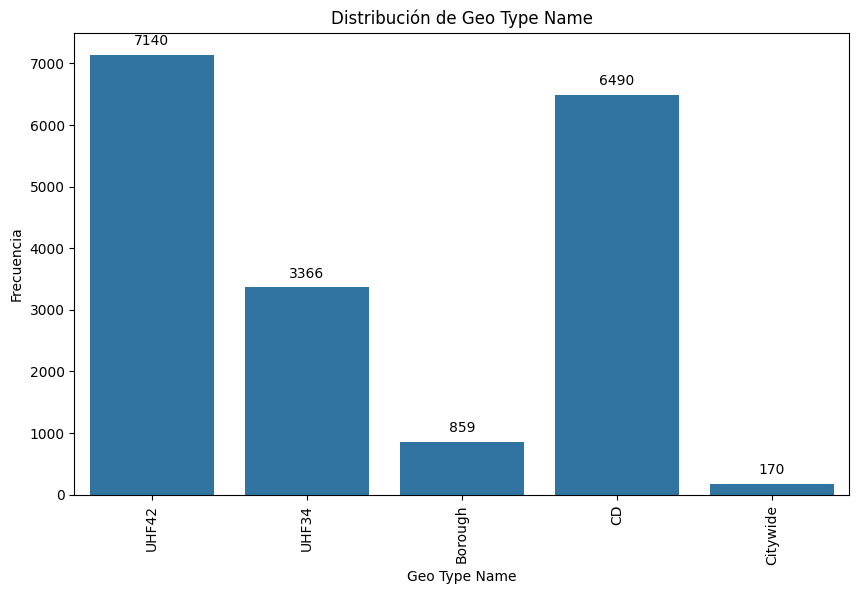


En la columna 'Geo Type Name' las categorías mas dominantes son: en primer lugar, 'UHF42' y, en segundo lugar, 'CD'.



,Categoria,Definicion
0,UHF42,UHF: United Hospital Fund (Fondo Unido del Hospital). UHF42 se refiere a las 42 áreas de análisis dentro de la ciudad de Nueva York designadas por el Fondo Unido del Hospital para la investigación y evaluación de la salud pública. Estas áreas permiten un análisis detallado y específico de los datos de salud a nivel comunitario.
1,UHF34,"Similar a UHF42, UHF34 se refiere a una división alternativa de la ciudad de Nueva York en 34 áreas para el análisis de datos de salud pública. Cada área de UHF34 comprende varias áreas de UHF42, proporcionando una visión más amplia y menos granular de los datos de salud."
2,Borough,"Un borough es una subdivisión administrativa dentro de una ciudad. En el contexto de Nueva York, los cinco boroughs son Manhattan, Brooklyn, Queens, The Bronx y Staten Island. Cada borough tiene su propio presidente y sistemas locales de gobierno."
3,CD,"CD: Community District (Distrito Comunitario). En la ciudad de Nueva York, un CD es una división geográfica creada para la planificación local y la administración de servicios comunitarios. Hay 59 distritos comunitarios en la ciudad, cada uno con su propio consejo comunitario."
4,Citywide,"Citywide se refiere a algo que afecta o incluye a toda la ciudad. En el contexto de los datos de salud o ambientales, citywide indicaría que los datos o las políticas se aplican en toda la ciudad de Nueva York, sin limitaciones a áreas específicas como boroughs o distritos comunitarios."


In [218]:
categorias = {
    'Name': [
        'Las emisiones totales de dióxido de azufre (SO2) producidas por calderas. El SO2 es un contaminante atmosférico que puede causar problemas respiratorios y contribuir a la lluvia ácida.', 
        'Partículas finas con un diámetro de 2.5 micrómetros o menos. Pueden penetrar profundamente en los pulmones y causar problemas de salud graves, como enfermedades respiratorias y cardiovasculares.', 
        'Dióxido de nitrógeno, un gas tóxico y contaminante atmosférico que puede irritar las vías respiratorias y agravar enfermedades pulmonares.', 
        'Visitas a las salas de emergencia por asma relacionadas con la exposición a partículas finas (PM2.5). La inhalación de PM2.5 puede desencadenar ataques de asma y otros problemas respiratorios.', 
        'Millas recorridas anualmente por vehículos. Este indicador se utiliza para medir la cantidad de tráfico y sus efectos en la calidad del aire.', 
        'Hospitalizaciones por problemas respiratorios en personas de 20 años o más, atribuibles a la exposición a partículas finas (PM2.5).', 
        'Ozono, un gas que puede ser beneficioso en la estratosfera (donde forma la capa de ozono) pero perjudicial a nivel del suelo, donde puede causar problemas respiratorios.', 
        'Hospitalizaciones por asma relacionadas con la exposición al ozono a nivel del suelo, que puede irritar y dañar las vías respiratorias.', 
        'Las emisiones totales de óxidos de nitrógeno (NOx) producidas por calderas. Los NOx son contaminantes que contribuyen a la formación de ozono troposférico y smog.', 
        'Las emisiones totales de partículas finas (PM2.5) producidas por calderas.', 
        'Formaldehído en el aire exterior. Es un compuesto químico tóxico utilizado en diversos procesos industriales y que puede causar problemas respiratorios y cáncer.', 
        'Visitas a las salas de emergencia por asma relacionadas con la exposición al ozono.', 
        'Hospitalizaciones por problemas cardiovasculares en personas de 40 años o más, atribuibles a la exposición a partículas finas (PM2.5).', 
        'Muertes relacionadas con problemas cardíacos y respiratorios debido a la exposición al ozono.', 
        'Muertes atribuibles a la exposición a partículas finas (PM2.5), que pueden causar enfermedades graves y mortales.', 
        'Benceno en el aire exterior. Es un hidrocarburo tóxico que se encuentra en emisiones industriales y vehiculares, y está asociado con el cáncer.', 
        'Millas recorridas anualmente por camiones. Este indicador se utiliza para medir el tráfico de camiones y su impacto en la calidad del aire.', 
        'Millas recorridas anualmente por automóviles. Este indicador se utiliza para medir el tráfico de automóviles y su impacto en la calidad del aire.'
    ], 
    'Measure': [
        'La cantidad de ocurrencias o entidades por kilómetro cuadrado. Esta medida se utiliza para expresar la densidad de algo en un área específica, como la densidad de población, vehículos, eventos, etc.', 
        'La media aritmética de un conjunto de valores. Se calcula sumando todos los valores y dividiéndolos por el número total de valores. Es una medida común de tendencia central en estadísticas.', 
        'La tasa anual estimada de un evento o condición específica en la población menor de 18 años. Esta tasa se calcula generalmente en función de datos históricos y proyecciones estadísticas.', 
        'Una medida de distancia que equivale a un millón de millas. Se puede utilizar para expresar grandes distancias recorridas, como en el caso de millas recorridas anualmente por vehículos.', 
        'La tasa anual estimada de un evento o condición específica en la población de 18 años o más. Esta tasa se basa en datos históricos y proyecciones para esa franja etaria.', 
        'La tasa anual estimada de un evento o condición específica, sin restricción de edad. Representa la frecuencia con la que se espera que ocurra un evento en un año determinado.', 
        'La concentración promedio anual de una sustancia o contaminante en el aire. Esta medida se utiliza para evaluar la exposición a largo plazo de poblaciones a ciertos contaminantes y es crucial en estudios de calidad del aire.', 
        'La tasa anual estimada de un evento o condición específica en la población de 30 años o más. Similar a las tasas para otros grupos etarios, se basa en datos y proyecciones para esa franja de edad.'
    ], 
    'Measure Info': [
        'Un valor numérico que puede representar cualquier cantidad contable o medible. En el contexto de los datos, podría referirse a una cantidad específica de eventos, individuos, o cualquier otro elemento cuantificable.', 
        'Unidad de medida de concentración que indica la cantidad de una sustancia en microgramos presente en un metro cúbico de aire. Se utiliza comúnmente para medir la concentración de contaminantes en la atmósfera, como partículas finas (PM2.5).', 
        'Unidad de medida de concentración que indica el número de partes de una sustancia por mil millones de partes del total. Se usa para medir contaminantes en el aire y el agua a niveles muy bajos.', 
        'Una tasa que indica la frecuencia de un evento en un grupo de 100,000 niños. Es útil para normalizar datos y comparar la incidencia de eventos entre diferentes poblaciones o regiones.', 
        'Una medida de densidad que indica la cantidad de ocurrencias o entidades por milla cuadrada. Se utiliza para expresar densidades de población, eventos o fenómenos geográficos.', 
        'Una tasa que indica la frecuencia de un evento en un grupo de 100,000 adultos. Esta tasa permite comparar la incidencia de eventos entre diferentes poblaciones o regiones, normalizando los datos.', 
        'Similar a `mcg/m³`, esta unidad de medida de concentración indica la cantidad de una sustancia en microgramos presente en un metro cúbico de aire. Se utiliza comúnmente para medir la concentración de contaminantes en la atmósfera.', 
        'Una tasa que indica la frecuencia de un evento en un grupo de 100,000 individuos, sin importar la categoría de edad. Esta tasa permite comparar la incidencia de eventos entre diferentes poblaciones o regiones.'
    ], 
    'Geo Type Name': [
        'UHF: United Hospital Fund (Fondo Unido del Hospital). UHF42 se refiere a las 42 áreas de análisis dentro de la ciudad de Nueva York designadas por el Fondo Unido del Hospital para la investigación y evaluación de la salud pública. Estas áreas permiten un análisis detallado y específico de los datos de salud a nivel comunitario.', 
        'Similar a UHF42, UHF34 se refiere a una división alternativa de la ciudad de Nueva York en 34 áreas para el análisis de datos de salud pública. Cada área de UHF34 comprende varias áreas de UHF42, proporcionando una visión más amplia y menos granular de los datos de salud.', 
        'Un borough es una subdivisión administrativa dentro de una ciudad. En el contexto de Nueva York, los cinco boroughs son Manhattan, Brooklyn, Queens, The Bronx y Staten Island. Cada borough tiene su propio presidente y sistemas locales de gobierno.', 
        'CD: Community District (Distrito Comunitario). En la ciudad de Nueva York, un CD es una división geográfica creada para la planificación local y la administración de servicios comunitarios. Hay 59 distritos comunitarios en la ciudad, cada uno con su propio consejo comunitario.', 
        'Citywide se refiere a algo que afecta o incluye a toda la ciudad. En el contexto de los datos de salud o ambientales, citywide indicaría que los datos o las políticas se aplican en toda la ciudad de Nueva York, sin limitaciones a áreas específicas como boroughs o distritos comunitarios.'
    ]
}

interpretacion = {
    'Name': "En la columna 'Name' hay dos categorías dominantes: 'Fine particles' y 'Nitrogen dioxide'. Ambas poseen la misma cantidad.", 
    'Measure': "En la columna 'Measure' la categoría dominante es 'mean', también llamado promedio.", 
    'Measure Info': "En la columna 'Measure Info' las categorías dominantes son: en primer lugar, 'ppb' y, en segundo lugar, 'mcg/m3'.", 
    'Geo Type Name': "En la columna 'Geo Type Name' las categorías mas dominantes son: en primer lugar, 'UHF42' y, en segundo lugar, 'CD'."
}

for columna in columnas_categoricas:
    print(f'Análisis de la columna {columna}')
    plt.figure(figsize=(10, 6))
    bar_plot = sns.countplot(x=columna, data=air_quality)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=90)
    
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'), 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 10), 
                          textcoords = 'offset points')
    
    plt.show()
    print()
    print(interpretacion[columna])
    print()
    nombres_de_categorias = pd.DataFrame(air_quality[columna].unique(), columns=['Categoria'])
    definiciones_de_categorias = pd.DataFrame(categorias[columna], columns=['Definicion'])
    categorias_por_columna = pd.concat([nombres_de_categorias, definiciones_de_categorias], axis=1)
    display(categorias_por_columna)
    print()

## Correlaciones

### Correlaciones de Pearson, Spearman y Kendall

In [220]:
label_encoders = {}
for column in ['Name', 'Measure', 'Measure Info', 'Geo Type Name']:
    le = LabelEncoder()
    air_quality[f'{column}_Encoded'] = le.fit_transform(air_quality[column])
    label_encoders[column] = le

def calcular_correlaciones(air_quality, columna_categorica, columna_numerica):
    pearson_corr = pearsonr(air_quality[columna_categorica], air_quality[columna_numerica])[0]
    spearman_corr = spearmanr(air_quality[columna_categorica], air_quality[columna_numerica])[0]
    kendall_corr = kendalltau(air_quality[columna_categorica], air_quality[columna_numerica])[0]
    
    print(f"Correlaciones con {columna_categorica}:")
    print(f"Pearson: {pearson_corr:.2f}")
    print(f"Spearman: {spearman_corr:.2f}")
    print(f"Kendall: {kendall_corr:.2f}")
    print()

for column in ['Name_Encoded', 'Measure_Encoded', 'Measure Info_Encoded', 'Geo Type Name_Encoded']:
    calcular_correlaciones(air_quality, column, 'Data Value')

Correlaciones con Name_Encoded:
Pearson: -0.37
Spearman: 0.27
Kendall: 0.27

Correlaciones con Measure_Encoded:
Pearson: 0.04
Spearman: 0.05
Kendall: 0.04

Correlaciones con Measure Info_Encoded:
Pearson: 0.27
Spearman: 0.52
Kendall: 0.36

Correlaciones con Geo Type Name_Encoded:
Pearson: 0.06
Spearman: 0.00
Kendall: 0.00



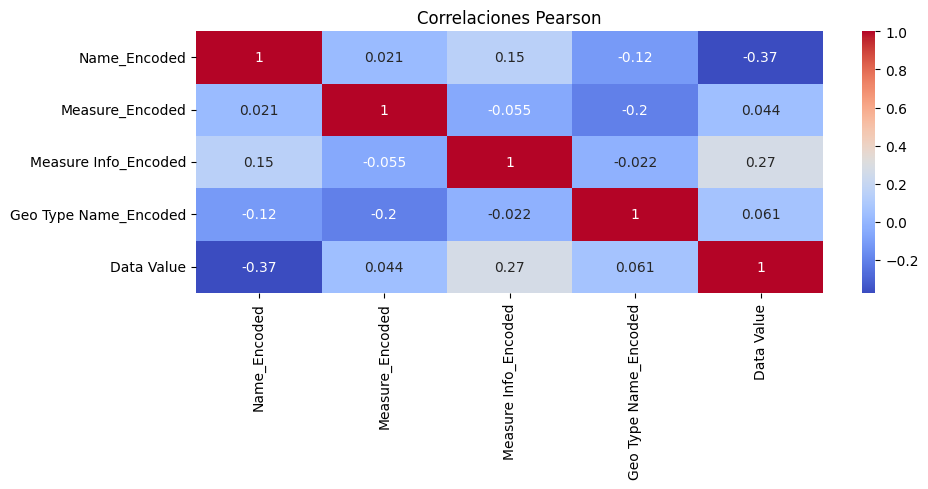

No existe una relacion lineal importante entre las variables.



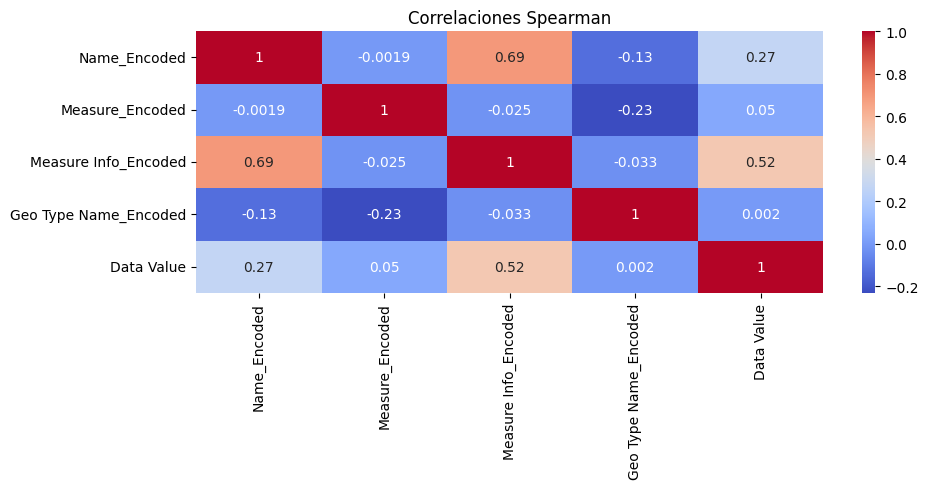

Existe una relacion interesante las columnas 'Measure_Info' y 'Name'. Ademas se observa una relacion a la mitad entre las columnas 'Measure_Info' y 'Data Value'



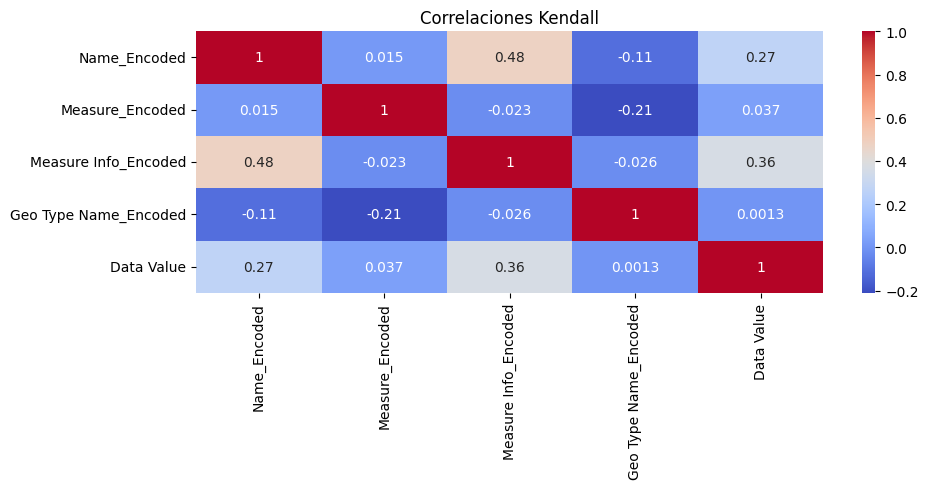

Hay una tibia relacion entre las columnas 'Measure_Info' y 'Name'



In [225]:
interpretacion = {
    'pearson': "No existe una relacion lineal importante entre las variables.", 
    'spearman': "Existe una relacion interesante las columnas 'Measure_Info' y 'Name'. Ademas se observa una relacion a la mitad entre las columnas 'Measure_Info' y 'Data Value'", 
    'kendall': "Hay una tibia relacion entre las columnas 'Measure_Info' y 'Name'"
}

label_encoders = {}
for column in ['Name', 'Measure', 'Measure Info', 'Geo Type Name']:
    le = LabelEncoder()
    air_quality[f'{column}_Encoded'] = le.fit_transform(air_quality[column])
    label_encoders[column] = le

correlation_methods = ['pearson', 'spearman', 'kendall']
correlations = {}

for method in correlation_methods:
    corr_matrix = air_quality[['Name_Encoded', 'Measure_Encoded', 'Measure Info_Encoded', 'Geo Type Name_Encoded', 'Data Value']].corr(method=method)
    correlations[method] = corr_matrix

for method in correlation_methods:
    plt.figure(figsize=(10, 5))
    sns.heatmap(correlations[method], annot=True, cmap='coolwarm')
    plt.title(f'Correlaciones {method.capitalize()}')
    plt.tight_layout()
    plt.show()
    print(interpretacion[method])
    print()

Conclusión: Los datos estan fuertemente agrupados en unos rangos. La mas fuerte relación es entre 'Measure Info' y 'Name'.